In [1]:
import cudf
from cuml.datasets import make_blobs
from cuml.neighbors import NearestNeighbors as cuNearestNeighbors

In [76]:
import numpy as np
import sys
import os
import argparse
import pickle
import fnmatch
from tqdm import tqdm
import re
import itertools
import random
import argparse
import matplotlib.pyplot as plt

ROOTDIR = '/mindhive/evlab/u/Shared/Greta_Eghbal_manifolds/'
model_identifier = 'NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.000161_sigma=5.0_nfeat=936-train_test-fixed'
train_identifier = 'epochs-10_batch-32_lr-0.01_momentum-0.5_init-gaussian_std-1e-06'
analyze_identifier = 'mftma-exm_per_class=50-proj=False-rand=True-kappa=1e-08-n_t=300-n_rep=5'

hier_idx = 4
layer = 'layer_2_Linear'
num_subsamples = 100
k = 100

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-g2r2sck2 because the default path (/home/gretatu/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [5]:
def main(raw_args=None):
    # Mapping specific
    parser = argparse.ArgumentParser(description='Compute KNN')
    parser.add_argument('--ROOTDIR', default='/mindhive/evlab/u/Shared/Greta_Eghbal_manifolds/', type=str)
    parser.add_argument('--model_identifier', default='NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.000161_sigma=5.0_nfeat=936-train_test-fixed',
                        type=str, help='Model ID str')
    parser.add_argument('--train_identifier', default='epochs-10_batch-32_lr-0.01_momentum-0.5_init-gaussian_std-1e-06', type=str)
    parser.add_argument('--analyze_identifier', default='mftma-exm_per_class=50-proj=False-rand=True-kappa=1e-08-n_t=300-n_rep=5', type=str)
    parser.add_argument('--layer', default='layer_2_Linear', type=str, help='Model layer of interest')
    parser.add_argument('--num_subsamples', default='100', type=str, help='Number of subsamples per time point')
    parser.add_argument('--hier_idx', default='4', type=str, help='Hierarchy number, starts at 0 (leaf)')
    parser.add_argument('--k', default='100', type=str, help='Number of neighbors')

    args = parser.parse_args(raw_args)

    print('*' * 40)
    print(vars(args))
    print('*' * 40)
    
    layer = args.layer
    num_subsamples = int(args.num_subsamples)
    hier_idx = int(args.hier_idx)
    k = int(args.k)
    

# Get extracted files for KNN sampling!
# /extracted/mftma-exm_per_class=50-proj=False-rand=True-kappa=1e-08-n_t=300-n_rep=5/NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.000161_sigma=5.0_nfeat=936-train_test-fixed/epochs-10_batch-32_lr-0.01_momentum-0.5_init-gaussian_std-1e-06

In [5]:
device_data, _ = make_blobs(n_samples=5,
                            n_features=100,
                            centers=5,
                            random_state=0)



In [7]:
device_data.type()

AttributeError: 'cupy.core.core.ndarray' object has no attribute 'type'

In [8]:
device_data = cudf.DataFrame(device_data)

In [9]:
device_data.type()

AttributeError: 'DataFrame' object has no attribute 'type'

In [11]:
knn_cuml = cuNearestNeighbors()
knn_cuml.fit(device_data)
D_cuml, I_cuml = knn_cuml.kneighbors(device_data, 3)

In [12]:
D_cuml

,0,1,2
0,0.022097,15.289548,15.979227
1,0.000000,74.751656,75.063850
2,0.022097,13.590247,15.979227
3,0.022097,13.376369,16.026751
4,0.000000,13.376369,13.590247


In [13]:
I_cuml

,0,1,2
0,0,4,2
1,1,0,4
2,2,4,0
3,3,4,0
4,4,3,2


In [15]:
# Try with numpy array as device data
test_data = np.random.rand(10,10)

In [16]:
test_data

array([[0.33033482, 0.20464863, 0.61927097, 0.29965467, 0.26682728,
        0.62113383, 0.52914209, 0.13457995, 0.51357812, 0.18443987],
       [0.78533515, 0.85397529, 0.49423684, 0.84656149, 0.07964548,
        0.50524609, 0.0652865 , 0.42812233, 0.09653092, 0.12715997],
       [0.59674531, 0.226012  , 0.10694568, 0.22030621, 0.34982629,
        0.46778748, 0.20174323, 0.64040673, 0.48306984, 0.50523672],
       [0.38689265, 0.79363745, 0.58000418, 0.1622986 , 0.70075235,
        0.96455108, 0.50000836, 0.88952006, 0.34161365, 0.56714413],
       [0.42754596, 0.43674726, 0.77655918, 0.53560417, 0.95374223,
        0.54420816, 0.08209492, 0.3663424 , 0.8508505 , 0.40627504],
       [0.02720237, 0.24717724, 0.06714437, 0.99385201, 0.97058031,
        0.80025835, 0.60181712, 0.76495986, 0.16922545, 0.29302323],
       [0.52406688, 0.35662428, 0.04567897, 0.98315345, 0.44135492,
        0.50400044, 0.32354132, 0.25974475, 0.38688989, 0.8320169 ],
       [0.73674706, 0.37921057, 0.0130173

In [17]:
device_data = cudf.DataFrame(test_data)

In [18]:
device_data

,0,1,2,3,4,5,6,7,8,9
0,0.330335,0.204649,0.619271,0.299655,0.266827,0.621134,0.529142,0.134580,0.513578,0.184440
1,0.785335,0.853975,0.494237,0.846561,0.079645,0.505246,0.065287,0.428122,0.096531,0.127160
2,0.596745,0.226012,0.106946,0.220306,0.349826,0.467787,0.201743,0.640407,0.483070,0.505237
3,0.386893,0.793637,0.580004,0.162299,0.700752,0.964551,0.500008,0.889520,0.341614,0.567144
4,0.427546,0.436747,0.776559,0.535604,0.953742,0.544208,0.082095,0.366342,0.850851,0.406275
5,0.027202,0.247177,0.067144,0.993852,0.970580,0.800258,0.601817,0.764960,0.169225,0.293023
6,0.524067,0.356624,0.045679,0.983153,0.441355,0.504000,0.323541,0.259745,0.386890,0.832017
7,0.736747,0.379211,0.013017,0.797405,0.269389,0.582685,0.025551,0.662202,0.387523,0.497074
8,0.414906,0.350872,0.550978,0.972911,0.112776,0.313259,0.041798,0.738400,0.657512,0.214636
9,0.416753,0.643842,0.661481,0.170477,0.881652,0.778008,0.133954,0.868917,0.748778,0.798586


In [19]:
knn_cuml = cuNearestNeighbors()
knn_cuml.fit(device_data)
D_cuml, I_cuml = knn_cuml.kneighbors(device_data, 3)

In [20]:
D_cuml

,0,1,2
0,0.000691,0.915151,1.018838
1,0.000691,0.884102,0.930939
2,0.000488,0.667324,0.915151
3,0.000000,0.671808,1.066851
4,0.000691,0.817937,1.018838
5,0.000000,1.139232,1.238284
6,0.000000,0.692844,0.945248
7,0.000000,0.667324,0.692844
8,0.000691,0.824889,0.930939
9,0.000977,0.671808,0.817937


In [21]:
extracted_files = []
for file in os.listdir(os.path.join(ROOTDIR, 'extracted', analyze_identifier, model_identifier, train_identifier)):
    if fnmatch.fnmatch(file, f'*{layer}_extracted.pkl'):
        extracted_files.append(os.path.join(ROOTDIR, 'extracted', analyze_identifier, model_identifier, train_identifier, file))

assert(len(extracted_files) == 1060)

s = [re.findall('/\d+', x) for x in extracted_files]
s = [item for sublist in s for item in sublist]
dummy_id = [(x.split('/')) for x in s]
file_id = [int(x.split('/')[1]) for x in s]
sorted_files = [extracted_files[x] for x in np.argsort(file_id)]

In [47]:

# Subsample
data = []
targets = []
epochs = []
subepochs = []

In [29]:
g = pickle.load(open(sorted_files[0],'rb'))
print(sorted_files[0])

/mindhive/evlab/u/Shared/Greta_Eghbal_manifolds/extracted/mftma-exm_per_class=50-proj=False-rand=True-kappa=1e-08-n_t=300-n_rep=5/NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.000161_sigma=5.0_nfeat=936-train_test-fixed/epochs-10_batch-32_lr-0.01_momentum-0.5_init-gaussian_std-1e-06/0000_NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.000161_sigma=5.0_nfeat=936-train_test-fixed-epoch=01-batchidx=15_layer_2_Linear_extracted.pkl


In [30]:
t = sorted_files[0].split('batchidx=')[1]
batchidx = t.split('_')[0]

In [31]:
t2 = sorted_files[0].split('epoch=')[1]
epoch = t2.split('-')[0]

In [32]:
print(f'Running epoch {epoch}, batchidx {batchidx}')

Running epoch 01, batchidx 15


In [33]:
for hier in range(len(g['projection_results'])):
    print(g['projection_results'][hier].keys())

dict_keys(['layer_2_Linear'])
dict_keys(['layer_2_Linear'])
dict_keys(['layer_2_Linear'])
dict_keys(['layer_2_Linear'])
dict_keys(['layer_2_Linear'])
dict_keys(['layer_2_Linear'])


In [40]:
len(g['projection_results'][hier][layer])

2

In [42]:
np.asarray(g['projection_results'][hier][layer]).shape

(2, 208, 50)

In [48]:
projs = g['projection_results']
hier = np.asarray(projs[hier_idx][layer])

In [49]:
hier_moved = np.moveaxis(hier, 1, -1)

In [50]:
hier_moved.shape[0]

4

In [51]:
# reshape into # classes, # samples, # features
hier_moved = np.moveaxis(hier, 1, -1)
print(hier_moved.shape)

# flatten samples
hier_flat = np.reshape(hier_moved, [hier_moved.shape[0]*hier_moved.shape[1], hier_moved.shape[2]])
print(hier_flat.shape)

(4, 50, 208)
(200, 208)


In [38]:
# test flattening
print(f'Sample 1 from class 1: {hier_moved[0,0,:2]}')
print(f'Sample 2 from class 1: {hier_moved[0,1,:2]}')

print(f'Sample 1 from class 2: {hier_moved[1,0,:2]}')
print(f'Sample 2 from class 2: {hier_moved[1,1,:2]}')

print(f'Sample 1 flattened: {hier_flat[0][:2]}')
print(f'Sample 2 flattened: {hier_flat[1][:2]}')
print(f'Sample 51 flattened: {hier_flat[50][:2]}')
print(f'Sample 52 flattened: {hier_flat[51][:2]}')
# ie the first 50 samples (rows) correspond to class 1, the next 50 rows for class 2 etc

Sample 1 from class 1: [ 0.00030159 -0.00033931]
Sample 2 from class 1: [-0.00019432 -0.00047235]
Sample 1 from class 2: [-9.4974421e-05  4.1729183e-04]
Sample 2 from class 2: [-0.00046068 -0.00047937]
Sample 1 flattened: [ 0.00030159 -0.00033931]
Sample 2 flattened: [-0.00019432 -0.00047235]
Sample 51 flattened: [-9.4974421e-05  4.1729183e-04]
Sample 52 flattened: [-0.00046068 -0.00047937]


In [52]:
targets_array = np.asarray([[(i+1)]*hier_moved.shape[1] for i in range(hier_moved.shape[0])])

In [53]:
targets_flatten = targets_array.ravel()

In [54]:
sample_idx = random.sample(range(hier_flat.shape[0]), num_subsamples)

subsampled_data = hier_flat[sample_idx, :]
subsampled_targets = targets_flatten[sample_idx]

assert(len(subsampled_data) == num_subsamples)

In [58]:
subsampled_data.shape

(100, 208)

In [55]:
data.append(subsampled_data)
targets.append(targets_flatten)
epochs.append(epoch*num_subsamples)
subepochs.append(batchidx*num_subsamples)

In [56]:
len(data)

1

In [62]:
production_time = list(range(1, len(epoch))) 
time = list(range(1, len(sorted_files)))
rel_time = np.divide(production_time,max(production_time))

In [67]:
device_data = cudf.DataFrame(data[0])

In [68]:
knn_cuml = cuNearestNeighbors()
knn_cuml.fit(device_data)
D_cuml, I_cuml = knn_cuml.kneighbors(device_data, 5)

In [69]:
D_cuml

,0,1,2,3,4
0,0.000003,0.003273,0.003784,0.004865,0.005069
1,0.000000,0.003541,0.004490,0.004490,0.005092
2,0.000000,0.003792,0.004923,0.005139,0.005253
3,0.000000,0.003153,0.003597,0.004485,0.004545
4,0.000000,0.003266,0.003492,0.004223,0.004861
...,...,...,...,...,...
95,0.000000,0.003404,0.004921,0.005480,0.006349
96,0.000004,0.003431,0.004733,0.005551,0.005986
97,0.000000,0.003873,0.004019,0.005366,0.005694
98,0.000000,0.004928,0.005246,0.005682,0.005983


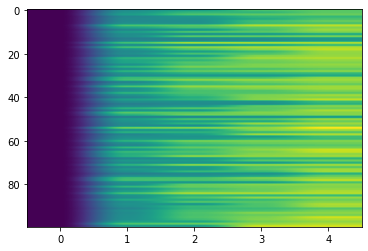

In [78]:
plt.imshow(D_cuml.as_matrix(),aspect='auto')

In [ ]:
with open(stimuli_file, 'wb') as f:
    pickle.dump(stimuli, f) 

In [ ]:
if __name__ == '__main__':
    main()
